In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Paths & Config

In [21]:
TRAIN_DIR = "../data/processed/train"
VAL_DIR = "../data/processed/val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10


### Data Generators

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


### Load Data from Directory

In [23]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
class_indices = train_gen.class_indices
class_indices

Found 433 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


{'burger': 0,
 'cake': 1,
 'french_fries': 2,
 'ice_cream': 3,
 'paneer': 4,
 'pasta': 5,
 'pizza': 6,
 'salad': 7,
 'sandwich': 8}

### Load Pre-trained MobileNetV2

In [24]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

### Freeze Base Layers

In [25]:
for layer in base_model.layers:
    layer.trainable = False


### Custom Classification Head

In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


### Compile Model

In [27]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


### Train Model

In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1109 - loss: 2.9859 - val_accuracy: 0.1611 - val_loss: 2.2951
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 894ms/step - accuracy: 0.1293 - loss: 2.5422 - val_accuracy: 0.2500 - val_loss: 2.0844
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 898ms/step - accuracy: 0.1709 - loss: 2.2481 - val_accuracy: 0.3167 - val_loss: 1.9311
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 878ms/step - accuracy: 0.2841 - loss: 2.0039 - val_accuracy: 0.4111 - val_loss: 1.7968
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 892ms/step - accuracy: 0.3002 - loss: 1.8769 - val_accuracy: 0.4722 - val_loss: 1.6831
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 852ms/step - accuracy: 0.3788 - loss: 1.7768 - val_accuracy: 0.5611 - val_loss: 1.5841
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 838ms/step - accuracy: 0.3857 - loss: 1.7054 - val_accuracy: 0.6111 - val_loss: 1.4904
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 829ms/step - accuracy: 0.4296 - loss: 1.6734 - val_accurac

### Results

Train Accuracy ≈ 52%

Val Accuracy ≈ 69.4%

In [29]:
model.save("../models/mobilenet_food_classifier.h5")


### Plot Training Curves

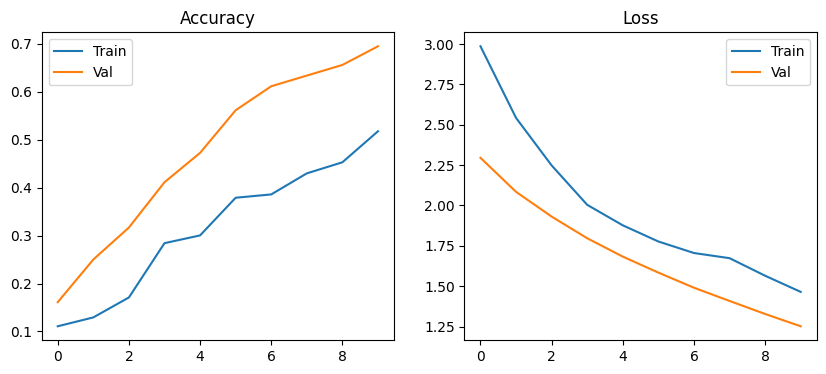

In [30]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


## Fine-Tuning

In [31]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


### Recompile

In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # VERY LOW LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [33]:
fine_tune_epochs = 10

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3695 - loss: 1.8609 - val_accuracy: 0.6944 - val_loss: 1.2102
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 970ms/step - accuracy: 0.3788 - loss: 1.7451 - val_accuracy: 0.7167 - val_loss: 1.1746
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 995ms/step - accuracy: 0.3718 - loss: 1.7055 - val_accuracy: 0.7333 - val_loss: 1.1378
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 967ms/step - accuracy: 0.4249 - loss: 1.6543 - val_accuracy: 0.7389 - val_loss: 1.1038
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4734 - loss: 1.5258 - val_accuracy: 0.7389 - val_loss: 1.0691
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4965 - loss: 1.5132 - val_accuracy: 0.7389 - val_loss: 1.0359
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5035 - loss: 1.4727 - val_accuracy: 0.7333 - val_loss: 1.0041
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 990ms/step - accuracy: 0.5335 - loss: 1.3958 - val_accuracy: 0.7389

### Results

Train Accuracy ≈ 58%

Val Accuracy   ≈ 76%


### More Finetuning with More Epoch and earlystop 

In [34]:
for layer in base_model.layers[-80:]:
    layer.trainable = True


In [35]:
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5450 - loss: 1.3722 - val_accuracy: 0.7667 - val_loss: 0.8262
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6282 - loss: 1.2071 - val_accuracy: 0.7944 - val_loss: 0.7488
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6651 - loss: 1.0750 - val_accuracy: 0.8333 - val_loss: 0.6775
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6813 - loss: 1.0420 - val_accuracy: 0.8389 - val_loss: 0.6104
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7367 - loss: 0.8984 - val_accuracy: 0.8500 - val_loss: 0.5525
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7575 - loss: 0.8253 - val_accuracy: 0.8611 - val_loss: 0.4990
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7621 - loss: 0.7761 - val_accuracy: 0.8722 - val_loss: 0.4530
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8106 - loss: 0.6482 - val_accuracy: 0.8833 - val_loss:

### Results

Train Accuracy      ≈ 97.7%

Validation Accuracy ≈ 97.2%

Validation Loss     ≈ 0.11


In [37]:
model.save("../models/mobilenet_food_classifier.h5")


In [38]:
class_indices = train_gen.class_indices
class_indices


{'burger': 0,
 'cake': 1,
 'french_fries': 2,
 'ice_cream': 3,
 'paneer': 4,
 'pasta': 5,
 'pizza': 6,
 'salad': 7,
 'sandwich': 8}